In [1]:
import tensorflow as tf
import time
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from tqdm import tqdm
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
import os
import importlib

In [2]:
dir_ml = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/out'
randseed = 42
print("random seed: ", randseed)
np.random.seed(randseed)

def choose_data(dat, test_size, val_size):
    if dat == 'ml2':
        train = pd.read_csv(os.path.join(dir_ml, 'ml_train2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        test = pd.read_csv(os.path.join(dir_ml, 'ml_test2.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        val = None  # Assuming no validation set for 'ml2'
        user_ids = train['userId'].unique()
        item_ids = train['songId'].unique()
        n_users = len(user_ids)
        n_items = len(item_ids)
    elif dat == 'ml':
        ml_full = pd.read_csv(os.path.join(dir_ml, 'ml-1m_full.csv'), sep="\t", header=None, names=['userId', 'songId', 'rating'], usecols=[0, 1, 2], engine="python")
        user_ids = ml_full['userId'].unique()
        item_ids = ml_full['songId'].unique()
        n_users = len(user_ids)
        n_items = len(item_ids)
        train, test = train_test_split(ml_full, test_size=test_size, random_state=42)
        train, val = train_test_split(train, test_size=val_size/(1-test_size), random_state=42)
    else:
        print('Wrong data input')
        return None, None, None, None, None

    print(f"Train set size: {train.shape[0]} ratings")
    print(f"Test set size: {test.shape[0]} ratings")
    return train, test, val, n_users, n_items

def load_confounders(dat, k, contype):
    CAUSEFIT_DIR = f'C:/Users/Sten Stokroos/Desktop/NEW/zelf/Data/exposure_output/{dat}_exp_k_{k}.csv'
    conf_df = pd.read_csv(CAUSEFIT_DIR, header=None)
    confounder_data = conf_df.to_numpy().T
    return confounder_data

def load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=False, test_size=0.1, val_size=0.1):
    train, test, val, n_users, n_items = choose_data(dat, test_size, val_size)
    if train is None or test is None:
        return None, None, None, None, None

    if include_validation:
        vad = val
    else:
        if val is not None:
            train = pd.concat([train, val]).sort_values(by='userId').reset_index(drop=True)
        vad = None

    def build_matrix(df):
        rows = []
        cols = []
        ratings = []
        for line in df.itertuples():
            rows.append(line[1])
            cols.append(line[2])
            ratings.append(line[3])
        return csr_matrix((ratings, (rows, cols)), shape=(n_users, n_items)).todok()

    train_matrix = build_matrix(train)
    test_matrix = build_matrix(test)
    vad_matrix = build_matrix(vad) if vad is not None else None


    print("Load data finished. Number of users:", n_users, "Number of items:", n_items)
    return train_matrix, test_matrix, vad_matrix, n_users, n_items


random seed:  42


In [5]:
def run_model(module_name, class_name, k, contype='hpf', dat='ml', include_validation=False, use_confounder=False, use_exposure=False, test_size=0.1, val_size=0.1, 
              hidden_neuron=500, learning_rate=0.001, reg_rate=0.1, epoch=20, batch_size=200, verbose=False, T=1, display_step=1000, save_path=None):
    
    train, test, vad, user, item = load_data_rating(dat, columns=[0, 1, 2], sep="\t", include_validation=include_validation, test_size=test_size, val_size=val_size)
    
    print(f"Loaded data: train={train.shape}, test={test.shape}, vad={vad.shape if vad is not None else 'None'}, user={user}, item={item}")

    confounder_data = None
    exposure_data = None

    if use_confounder:
        confounder_data = load_confounders(dat, k, contype)
    if use_exposure:
        exposure_data = (train > 0).astype(np.float32).todense().T

    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True

    with tf.compat.v1.Session(config=config) as sess:
        module = importlib.import_module(module_name)
        model_class = getattr(module, class_name)
        final_model = model_class(sess, user, item, learning_rate=learning_rate, reg_rate=reg_rate, epoch=epoch, batch_size=batch_size, verbose=verbose, T=T, display_step=display_step)

        print(f"Final model created with hidden_neuron={hidden_neuron} and num_item={item}")

        final_model.build_network(hidden_neuron=hidden_neuron)
        
        if confounder_data is not None and exposure_data is not None:
            final_model.execute(train, test, confounder_data, exposure_data)
        elif confounder_data is not None:
            final_model.execute(train, test, confounder_data)
        else:
            final_model.execute(train, test)

        if save_path:
            class_folder = os.path.join(save_path, class_name.lower())
            os.makedirs(class_folder, exist_ok=True)

            train_loss_file = os.path.join(class_folder, f'{contype}{epoch}_LONGTUNEtrain_loss_{dat}_k{k}.npy')
            test_rmse_file = os.path.join(class_folder, f'{contype}{epoch}_LONGTUNEtest_rmse_{dat}_k{k}.npy')
            np.save(train_loss_file, np.array(final_model.train_loss_history))
            np.save(test_rmse_file, np.array(final_model.test_rmse_history))

            if confounder_data is not None and exposure_data is not None:
                final_rmse, final_mae = final_model.test(test, confounder_data, exposure_data)
            elif confounder_data is not None:
                final_rmse, final_mae = final_model.test(test, confounder_data)
            else:
                final_rmse, final_mae = final_model.test(test)

        print(f"Final RMSE: {final_rmse}, Final MAE: {final_mae}")

def run_all_models(result_path, models, k_values, contype):
    for c in contype:
        for k in k_values:
            for model in models:
                use_confounder = 'conf' in model['module_name']
                use_exposure = 'exp' in model['module_name']
                
                print(f"Running {model['class_name']} with k={k}, use_confounder={use_confounder}, use_exposure={use_exposure}")
                run_model(model['module_name'], model['class_name'], k , c, dat='ml', include_validation=False, use_confounder=use_confounder, use_exposure=use_exposure, test_size=0.1, val_size=0.1, hidden_neuron=500, 
                        learning_rate= 0.001914789208759444, reg_rate=0.2518369987917518, epoch=200, batch_size=512, verbose=True, save_path=result_path)
                
                print(f"Completed {model['class_name']} with k={k}")

In [6]:
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results2'

models = [
    # {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    # {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1conf'},
    # {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1confexp'},
    # {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2confexp'},
    # {'module_name': 'urec_2_confexp copy', 'class_name': 'UAutoRec2confexpcopy'}
    # {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3conf'},
    # {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3confexp'},
#     {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4conf'},
#     {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4confexp'}
]
# Best parameters for UAutoRec1conf in detailed form: {'learning_rate': 0.001914789208759444, 'reg_rate': 0.2518369987917518, 'hidden_neuron': 500, 'k': 5}
k_values = [5]
contype = ['hpf']

# Best parameters for UAutoRec2confexp in detailed form for 10 folds, early stopping 15 evaluations wiht 150 epochs: {'learning_rate': 0.0007588485431339859, 'reg_rate': 0.0964568931104186, 'hidden_neuron': 500, 'k': 100}


# Best parameters for UAutoRec1conf in detailed form: {'hidden_neuron': 2, 'k': 2, 'learning_rate': 0.0010302386102103937, 'reg_rate': 0.011602144650134006}
run_all_models(result_path, models, k_values, contype) #after this run the two tuned models!


Running UAutoRec2confexp with k=5, use_confounder=True, use_exposure=True
Train set size: 800169 ratings
Test set size: 100022 ratings
Load data finished. Number of users: 6040 Number of items: 3706
Loaded data: train=(6040, 3706), test=(6040, 3706), vad=None, user=6040, item=3706
UAutoRec with Confounder and Exposure.
Final model created with hidden_neuron=500 and num_item=3706


Training:  39%|███▉      | 78/200 [07:20<11:28,  5.65s/epoch, Loss=4.2e+4, RMSE=0.874, MAE=0.69]  


Early stopping at epoch 78. Best RMSE: 0.868355110471235
Final RMSE: 0.8739793120198653, Final MAE: 0.6896872820426838
Completed UAutoRec2confexp with k=5


uautorec (k=32, epoch=170, tuned=TUNED) - Train loss history shape: (170,)
uautorec (k=32, epoch=170, tuned=TUNED) - Test RMSE history shape: (170,)
Files for uautorec with k=32, epoch=200, tuned=TUNED not found.
Files for uautorec1conf with k=32, epoch=170, tuned=TUNED not found.
Files for uautorec1conf with k=32, epoch=200, tuned=TUNED not found.
Files for uautorec2confexp with k=32, epoch=170, tuned=TUNED not found.
Files for uautorec2confexp with k=32, epoch=200, tuned=TUNED not found.
Files for uautorec with k=100, epoch=170, tuned=TUNED not found.
Files for uautorec with k=100, epoch=200, tuned=TUNED not found.
Files for uautorec1conf with k=100, epoch=170, tuned=TUNED not found.
Files for uautorec1conf with k=100, epoch=200, tuned=TUNED not found.
uautorec2confexp (k=100, epoch=170, tuned=TUNED) - Train loss history shape: (170,)
uautorec2confexp (k=100, epoch=170, tuned=TUNED) - Test RMSE history shape: (170,)
uautorec2confexp (k=100, epoch=200, tuned=TUNED) - Train loss histor

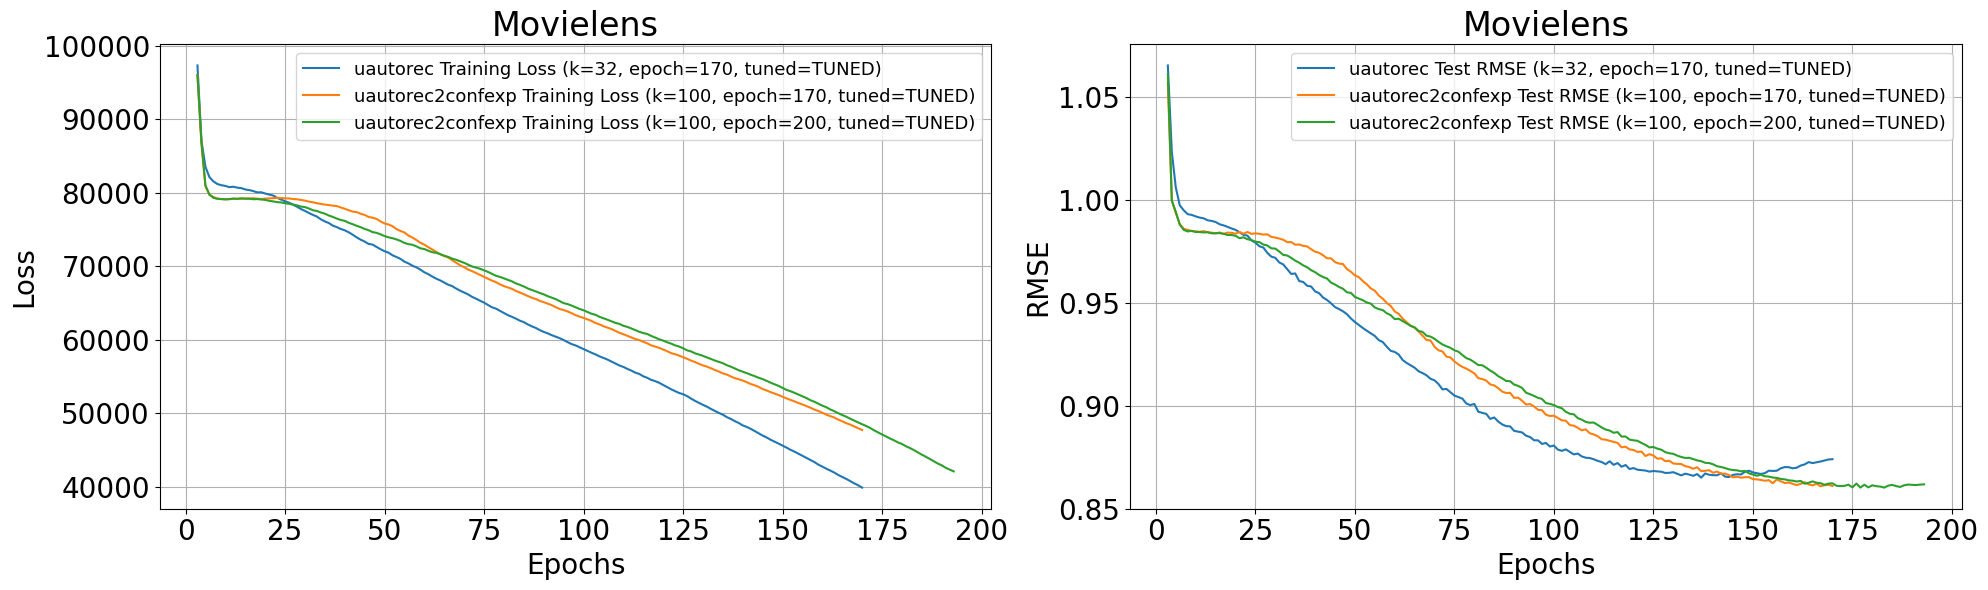

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_results(result_path, models, k_values, contype, epochs_list, tuned_list):
    plt.figure(figsize=(20, 6))

    for c in contype:
        for k in k_values:
            for model in models:
                class_name = model['class_name'].lower()
                class_folder = os.path.join(result_path, class_name)
                
                for epoch in epochs_list:
                    for tuned in tuned_list:
                        tuned_text = f'{tuned}_' if tuned else ''
                        train_loss_file = os.path.join(class_folder, f'{epoch}_{tuned_text}train_loss_ml_k{k}.npy')
                        test_rmse_file = os.path.join(class_folder, f'{epoch}_{tuned_text}test_rmse_ml_k{k}.npy')

                        if not os.path.exists(train_loss_file) or not os.path.exists(test_rmse_file):
                            print(f"Files for {class_name} with k={k}, epoch={epoch}, tuned={tuned} not found.")
                            continue

                        train_loss_history = np.load(train_loss_file)
                        test_rmse_history = np.load(test_rmse_file)

                        print(f"{class_name} (k={k}, epoch={epoch}, tuned={tuned}) - Train loss history shape: {train_loss_history.shape}")
                        print(f"{class_name} (k={k}, epoch={epoch}, tuned={tuned}) - Test RMSE history shape: {test_rmse_history.shape}")

                        epochs = np.arange(1, len(train_loss_history) + 1)

                        # Plot training loss
                        plt.subplot(1, 2, 1)
                        plt.plot(epochs[2:], train_loss_history[2:], label=f'{class_name} Training Loss (k={k}, epoch={epoch}, tuned={tuned})')

                        # Plot test RMSE
                        plt.subplot(1, 2, 2)
                        plt.plot(epochs[2:], test_rmse_history[2:], label=f'{class_name} Test RMSE (k={k}, epoch={epoch}, tuned={tuned})')

    plt.subplot(1, 2, 1)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Movielens', fontsize=24)
    plt.legend(fontsize=13)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('RMSE', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('Movielens', fontsize=24)
    plt.legend(fontsize=13)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'
models = [
    {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1Conf'},
    # {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1ConfExp'},
    # {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2Conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2ConfExp'},
    # {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3Conf'},
    {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3ConfExp'},
    # {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4Conf'},
    # {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4ConfExp'}
]
k_values = [32, 100]  # Add all the k values you want to plot
contype = ['hpf', 'mlp']
epochs_list = [170, 200]  # Add all the epoch sizes you want to plot
tuned_list = ['TUNED']  # Add the text variations to check

plot_results(result_path, models, k_values, contype, epochs_list, tuned_list)


In [2]:
import os
import numpy as np
import pandas as pd

def load_rmse_history(result_path, models, k_values):#, contype):
    results = []
    epoch = 170
    # for c in contype:
    for k in k_values:
        for model in models:
            class_name = model['class_name'].lower()
            class_folder = os.path.join(result_path, class_name)
            test_rmse_file = os.path.join(class_folder, f'{epoch}_test_rmse_ml_k{k}.npy')

            if not os.path.exists(test_rmse_file):
                print(f"Test RMSE file for {class_name} with k={k} not found.")
                continue

            test_rmse_history = np.load(test_rmse_file)
            final_rmse = test_rmse_history[-10]  # Last RMSE value
            best_rmse = np.min(test_rmse_history)  # Lowest RMSE value

            results.append({
                'Model': model['class_name'],
                'k': k,
                'Final RMSE': final_rmse,
                'Best RMSE': best_rmse
                # 'c': c
            })

    return pd.DataFrame(results)

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'

models = [
    {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1conf'},
    {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1confexp'},
    {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2confexp'},
    {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3conf'},
    {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3confexp'},
    {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4conf'},
    {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4confexp'}
]
k_values = [32]
contype = ['hpf']
results_df = load_rmse_history(result_path, models, k_values)#, contype)
print(results_df)

# Save the results to a CSV file if needed
# results_csv_file = os.path.join(result_path, 'rmse_results.csv')
# results_df.to_csv(results_csv_file, index=False)


              Model   k  Final RMSE  Best RMSE
0          UAutoRec  32    0.872945   0.864493
1     UAutoRec1conf  32    0.929261   0.869328
2  UAutoRec1confexp  32    0.961784   0.869936
3     UAutoRec2conf  32    0.869668   0.865084
4  UAutoRec2confexp  32    0.862732   0.859708
5     UAutoRec3conf  32    0.865819   0.865430
6  UAutoRec3confexp  32    0.871742   0.864749
7     UAutoRec4conf  32    0.927102   0.900108
8  UAutoRec4confexp  32    1.034784   0.990612


In [21]:
import os
import numpy as np
import pandas as pd

def load_rmse_history(result_path, models, k_values, epochs_list, tuned_list):
    results = []
    
    for k in k_values:
        for model in models:
            class_name = model['class_name'].lower()
            class_folder = os.path.join(result_path, class_name)
            
            for epoch in epochs_list:
                for tuned in tuned_list:
                    tuned_text = f'{tuned}_' if tuned else ''
                    test_rmse_file = os.path.join(class_folder, f'{epoch}_{tuned_text}test_rmse_ml_k{k}.npy')

                    if not os.path.exists(test_rmse_file):
                        print(f"Test RMSE file for {class_name} with k={k}, epoch={epoch}, tuned={tuned} not found.")
                        continue

                    test_rmse_history = np.load(test_rmse_file)
                    final_rmse = test_rmse_history[-1]  # Last RMSE value
                    best_rmse = np.min(test_rmse_history)  # Lowest RMSE value

                    results.append({
                        'Model': model['class_name'],
                        'k': k,
                        'Epoch': epoch,
                        'Tuned': tuned,
                        'Final RMSE': final_rmse,
                        'Best RMSE': best_rmse
                    })

    return pd.DataFrame(results)

# Example usage
result_path = 'C:/Users/Sten Stokroos/Desktop/NEW/zelf/results'

models = [
    {'module_name': 'urec_og', 'class_name': 'UAutoRec'},
    {'module_name': 'urec_1_conf', 'class_name': 'UAutoRec1conf'},
    # {'module_name': 'urec_1_confexp', 'class_name': 'UAutoRec1confexp'},
    # {'module_name': 'urec_2_conf', 'class_name': 'UAutoRec2conf'},
    {'module_name': 'urec_2_confexp', 'class_name': 'UAutoRec2confexp'},
#     {'module_name': 'urec_3_conf', 'class_name': 'UAutoRec3conf'},
#     {'module_name': 'urec_3_confexp', 'class_name': 'UAutoRec3confexp'},
#     {'module_name': 'urec_4_conf', 'class_name': 'UAutoRec4conf'},
#     {'module_name': 'urec_4_confexp', 'class_name': 'UAutoRec4confexp'}
]
k_values = [5, 32, 100]  # Add all the k values you want to compare
epochs_list = [170, 200]  # Add all the epoch sizes you want to compare
tuned_list = ['TUNED', '']  # Add the text variations to check

results_df = load_rmse_history(result_path, models, k_values, epochs_list, tuned_list)
print(results_df)

# Save the results to a CSV file if needed
results_csv_file = os.path.join(result_path, 'rmse_results.csv')
results_df.to_csv(results_csv_file, index=False)


Test RMSE file for uautorec with k=5, epoch=170, tuned=TUNED not found.
Test RMSE file for uautorec with k=5, epoch=170, tuned= not found.
Test RMSE file for uautorec with k=5, epoch=200, tuned=TUNED not found.
Test RMSE file for uautorec with k=5, epoch=200, tuned= not found.
Test RMSE file for uautorec1conf with k=5, epoch=170, tuned= not found.
Test RMSE file for uautorec1conf with k=5, epoch=200, tuned=TUNED not found.
Test RMSE file for uautorec1conf with k=5, epoch=200, tuned= not found.
Test RMSE file for uautorec2confexp with k=5, epoch=170, tuned=TUNED not found.
Test RMSE file for uautorec2confexp with k=5, epoch=170, tuned= not found.
Test RMSE file for uautorec2confexp with k=5, epoch=200, tuned=TUNED not found.
Test RMSE file for uautorec2confexp with k=5, epoch=200, tuned= not found.
Test RMSE file for uautorec with k=32, epoch=200, tuned=TUNED not found.
Test RMSE file for uautorec with k=32, epoch=200, tuned= not found.
Test RMSE file for uautorec1conf with k=32, epoch=